# Introduction to the ACCESS-NRI Intake catalog

**Aims**: This tutorial will introduce the ACCESS-NRI Intake catalog a show you how to use it to find and load model data for analysis

**Project membership requirements**:

 - If using the `xp65` conda environment: `xp65`, `dk92`, `fs38`, `p73`, `ik11` and `oi10`
 - If using the `hh5` conda environment: as above but also `hh5`


The ACCESS-NRI Intake Catalog is curated by ACCESS-NRI with further information on its <a href="https://access-nri-intake-catalog.readthedocs.io/en/latest/index.html" target="_blank">documentation website</a> and <a href="https://access-hive.org.au/model_evaluation/model_evaluation_model_catalogs" target="_blank">this ACCESS-Hive page</a>.

----

# The motivation

Data products (whether model output or observation based) are split across a collection of projects, in various formats and sometimes in a large number of files. 

This can be tricky, if the output is organised different for different model output. For example:
- ACCESS CMIP6 output is in `/g/data/fs38` and locally replicated CMIP6 output from other modelling centers is in `/g/data/oi10`
- Some model output (e.g. CICE) contains many variables in one history file, so its not clear what variables are available until opening the file.

A catalog provides functionality for searching, discovering and loading data. Data discovery is improved by facilitating a variety of search terms, including by name, model, realm (e.g. model component), data frequency, variable name and variable standard names (for CF-compliant output, these should be consistent across models.

In our case, the catalog is built using the [Intake-ESM](https://intake-esm.readthedocs.io/) framework, with python code added to capture ACCESS model output formats and to collate a set of common model output into one catalog.

# Using the catalog

The general process for using the catalog is as follows:

1. Search the ACCESS-NRI catalog for data products that are of interest to you.
   
   <img src="../assets/catalog-example.png" alt="Example intake-esm datastore" width=800/><br />
3. Open the Intake-ESM datastore(s) for the product(s) of interest. (N.B. assets = files with history/diagnostic output, dataset = output with consistent coordinates and frequency, which can be concatenated over time)

   <img src="../assets/datastore-example.png" alt="Example intake-esm datastore" width=600/><br />
5. Search the Intake-ESM datastore(s) for the datasets that are of interest to you.
6. Open the datasets of interest as xarray Dataset(s).
   
   <img src="../assets/dataset-example.png" alt="Example xarray dataset" width=800/></td>
8. Perform some analysis on the xarray Dataset(s).

This process is also illustrated in the schematic below. Pink text indicates the methods used to perform each task.

<img src="../assets/catalog_flow.svg" alt="Diagram of steps from having a catalog to getting an analysis ready dataset" width=600/>

If a user knows in advance the name of the product(s) they are after, then the first two steps above are not needed. Instead, those Intake-ESM datastores can be easily retreived directly from the catalog as demonstrated later on.

# Opening the catalog 

We'll now go through the steps in more detail. First we open the catalog

In [2]:
import intake

catalog = intake.cat.access_nri

With that, we can now use `catalog` to search and load ~3 PB of data without having to know where the data is or how it's structured. 

The catalog includes a wide variety of climate data products. The "name" column gives the name of the data product and the other columns provide additional metadata associated with each product. As we'll demonstrate below, you can search on metadata in these columns to filter for data products that may be of interest to you. Scroll through the products below and get an idea for what each product is by looking at the entry in the description column.

In [3]:
catalog

Each entry (row) in the catalog describes a data product comprising many datasets spread across many files (a "dataset" here is a set of files that can be readily opened and combined for analysis using xarray - more on this later). For example, in a given ACCESS-CM2 product, there may be a dataset of ocean variables at monthly frequency, atmospheric variables at monthly frequency etc. Each entry in the catalog has a corresponding Intake-ESM datastore that can be used to filter for datasets of interest based on metadata in the datastore and then to open those datasets using xarray.

# Catalog filtering and data discovery

We can search on the columns in the ACCESS-NRI catalog. For example, we could search for all products that use the model `ACCESS-OM2`. The `search` method returns another catalog object with entries that satisfy our search criteria.

In [4]:
catalog_filtered_example = catalog.search(model="ACCESS-OM2")
catalog_filtered_example

We can also combine queries in a search. For example, below we search for all products that use the model `ACCESS-OM2` and contain the variable `wdet100` at daily frequency.

In [5]:
catalog.search(model="ACCESS-OM2", frequency="1day", variable="wdet100")

We can also use regex strings in our searches. For example, we could relax our query on variable to look for any variables starting with the letter `"w"`.

In [6]:
catalog.search(model="ACCESS-OM2", frequency="1day", variable="w.*")

Note, metadata in the `realm` and `frequency` columns of the ACCESS-NRI catalog follow a standard vocabulary that is very similar to CMIP6 (but slightly more general):

 - `realm` may be one of:
   - `aerosol`,
   - `atmos`,
   - `atmosChem`,
   - `land`,
   - `landIce`,
   - `none`,
   - `ocean`,
   - `ocnBgchem`,
   - `seaIce`,
   - `unknown`
 - `frequency` may be one of (where `<int>` is an integer):
   - `fx`
   - `subhr`
   - `<int>hr`
   - `<int>day`
   - `<int>mon`
   - `<int>yr`
   - `<int>dec`
  
Some attempt has been made to use consistent model names in the `model` column (e.g. always use "ACCESS-OM2" for ACCESS-OM2), but model naming is not enforced. The variable names in the `variable` column are whatever they're called in the associated data product.

You can find the valid values for a field by using the "dataframe" view to select the field, and type it as a set to return the unique values.

In [7]:
set(catalog.search(model="ACCESS-*").df.model)

{('ACCESS-CM2',),
 ('ACCESS-ESM1-5',),
 ('ACCESS-OM2',),
 ('ACCESS-OM2-025',),
 ('ACCESS1-0',),
 ('ACCESS1-3',)}

Note that the ACCESS-NRI Intake Catalog contains the data products locally stored and replicated from CMIP6 results, and other locally produced model output. Sometimes these names can be confusing, for example data from models named 'ACCESS-OM2-025' contains results submitted to the Ocean MIP at a nominal 0.25 degree resolution using the CMOR standard variable. Data from models named 'ACCESS-OM2' also contains results at a nominal 0.25 degree resolution, however they used the model's chosen names for variables.

# Loading Intake sources

Each entry in the catalog has an associated Intake-ESM datastore that keeps track of all the files in that product and how they fit together into datasets. There are three ways to open Intake-ESM datastores from the catalog, depending on your use case:

## 1. You know the name of the product you want

In this case, you can open the Intake-ESM datastore for that product directly as an attribute or key. For example

In [8]:
datastore_example = catalog.by647

# Or

datastore_example = catalog["by647"]

In [9]:
datastore_example

## 2. You've filtered the catalog for the products you want and there are multiple remaining

In this case, you can open the Intake-ESM datastores for all entries in a catalog using the `to_source_dict` method. For example

In [10]:
datastore_dict_example = catalog.search(model="ACCESS-OM2", frequency="1day", variable="wdet100").to_source_dict()

In [11]:
datastore_dict_example

{'01deg_jra55v140_iaf_cycle4': <01deg_jra55v140_iaf_cycle4 catalog with 206 dataset(s) from 131730 asset(s)>,
 '01deg_jra55v140_iaf_cycle4_jra55v150_extension': <01deg_jra55v140_iaf_cycle4_jra55v150_extension catalog with 198 dataset(s) from 13399 asset(s)>}

## 3. You've filtered the catalog for the products you want and there's only one remaining 

In this case, you can open the Intake-ESM datastore for the remaining product using the `to_source` method (note you could also use `to_source_dict` which would return a dictionary containing the Intake-ESM datastore, rather than the datastore itself). For example

In [12]:
datastore_example = catalog.search(name="by647").to_source()

# Additional source metadata

Each Intake-ESM datastore has its own `.metadata` attribute that contains additional information about that experiment.

In [13]:
catalog.by647.metadata

{'contact': 'Dave Bi',
 'created': None,
 'description': 'Standard CMIP6 ssp245 simulation, control experiment for by578 pacemaker experiment (1fd9e682-d393-4b17-a9cd-934c3a48a1f8)',
 'email': 'dave.bi@csiro.au',
 'experiment_uuid': '57243597-43c0-4a8f-a404-b10cecdeb3f7',
 'keywords': [None],
 'license': None,
 'long_description': 'Standard CMIP6 ssp245 simulation with 5 ensemble members. Control experiment  for by578 pacemaker experiment (1fd9e682-d393-4b17-a9cd-934c3a48a1f8). Branched from parent experiment in 2015',
 'model': ['ACCESS-CM2'],
 'name': 'by647',
 'nominal_resolution': ['atmos = n96', 'ocean = 1 degree'],
 'notes': 'null',
 'parent_experiment': '1c6e73fb-5380-43c1-8043-0526be2f1b8b',
 'reference': None,
 'related_experiments': ['1fd9e682-d393-4b17-a9cd-934c3a48a1f8'],
 'url': None,
 'version': 1,
 'catalog_dir': ''}

# Finding a variable and a simple workflow

Now we can use our Intake-ESM datastores to open the data we want. We'll show the basics here and refer to the Intake-ESM documentation [here](https://intake-esm.readthedocs.io/en/stable/index.html) for more information on how to use Intake-ESM datastores.

We are going to open the the Sea surface salinity from the experiment named _025deg_jra55_iaf_omip2_cycle6_ as an xarray dataset. Lets start by having a look at the available variables, to figure out the variable name

There is a catalog _dataframe_ view, which has one line per data file ... too much information to parse easily:

In [14]:
catalog['025deg_jra55_iaf_omip2_cycle6'].df

path  \
0     /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output305/ice/OUTPUT/iceh.1958-01-daily.nc   
1           /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output305/ice/OUTPUT/iceh.1958-01.nc   
2     /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output305/ice/OUTPUT/iceh.1958-02-daily.nc   
3           /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output305/ice/OUTPUT/iceh.1958-02.nc   
4     /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output305/ice/OUTPUT/iceh.1958-03-daily.nc   
5           /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output305/ice/OUTPUT/iceh.1958-03.nc   
6     /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output305/ice/OUTPUT/iceh.1958-04-daily.nc   
7           /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output305/ice/OUTPUT/iceh.1958-04.nc   
8     /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output305/ice/OUTPUT/iceh.1958-05-daily.nc   
9           /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output305/ice/OUTPUT/iceh.1958-05.nc   
10    /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output305/ice/OUTPUT/iceh.1958-06-daily.nc   
11          /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output305/ice/OUTPUT/iceh.1958-06.nc   
12    /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output305/ice/OUTPUT/iceh.1958-07-daily.nc   
13          /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output305/ice/OUTPUT/iceh.1958-07.nc   
14    /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output305/ice/OUTPUT/iceh.1958-08-daily.nc   
15          /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output305/ice/OUTPUT/iceh.1958-08.nc   
16    /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output305/ice/OUTPUT/iceh.1958-09-daily.nc   
17          /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output305/ice/OUTPUT/iceh.1958-09.nc   
18    /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output305/ice/OUTPUT/iceh.1958-10-daily.nc   
19          /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output305/ice/OUTPUT/iceh.1958-10.nc   
20    /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output305/ice/OUTPUT/iceh.1958-11-daily.nc   
21          /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output305/ice/OUTPUT/iceh.1958-11.nc   
22    /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output305/ice/OUTPUT/iceh.1958-12-daily.nc   
23          /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output305/ice/OUTPUT/iceh.1958-12.nc   
24               /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output305/ocean/ocean_budget.nc   
25                /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output305/ocean/ocean_daily.nc   
26                 /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output305/ocean/ocean_grid.nc   
27                /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output305/ocean/ocean_month.nc   
28               /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output305/ocean/ocean_scalar.nc   
29      /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output305/ocean/ocean_scalar_snapshot.nc   
30    /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output306/ice/OUTPUT/iceh.1959-01-daily.nc   
31          /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output306/ice/OUTPUT/iceh.1959-01.nc   
32    /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output306/ice/OUTPUT/iceh.1959-02-daily.nc   
33          /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output306/ice/OUTPUT

We can refine it using search

In [15]:
catalog_search = catalog['025deg_jra55_iaf_omip2_cycle6'].search(frequency='1mon', realm='ocean')
catalog_search

Our search returned 3 _file_id_, meaning we still have three distinct datasets. Lets have a look to see if we can refine out search further

In [67]:
set(catalog_search.df.file_id)

{'ocean_budget', 'ocean_month', 'ocean_scalar'}

We want a gridded sea surface temperature, so we will use _ocean_month_

In [68]:
catalog_search = catalog_search.search(file_id='ocean_month')

In [70]:
catalog_search

We only have one _file_id_ now, meaning there is a distinct dataset, so we can look at the avalable variables (the variables in the first entry and the same at this point for all entries, a.k.a. files in the search)

In [71]:
catalog_search.df.variable[0]

['pbot_t',
 'patm_t',
 'rho_dzt',
 'dht',
 'sea_level',
 'sea_level_sq',
 'pot_temp',
 'temp',
 'sst',
 'sst_sq',
 'bottom_temp',
 'salt',
 'sss',
 'sss_sq',
 'bottom_salt',
 'age_global',
 'mld',
 'mld_max',
 'mld_min',
 'mld_sq',
 'psiu',
 'psiv',
 'bv_freq',
 'buoyfreq2_wt',
 'hblt_max',
 'pot_rho_0',
 'pot_rho_2',
 'rho',
 'eta_t',
 'u',
 'v',
 'wt',
 'tx_trans',
 'ty_trans',
 'tz_trans',
 'tx_trans_gm',
 'ty_trans_gm',
 'tx_trans_submeso',
 'ty_trans_submeso',
 'tx_trans_rho',
 'ty_trans_rho',
 'tx_trans_rho_gm',
 'ty_trans_rho_gm',
 'tx_trans_nrho_submeso',
 'ty_trans_nrho_submeso',
 'tx_trans_int_z',
 'ty_trans_int_z',
 'temp_xflux_adv_int_z',
 'temp_yflux_adv_int_z',
 'temp_yflux_gm_int_z',
 'temp_xflux_gm_int_z',
 'temp_xflux_ndiffuse_int_z',
 'temp_yflux_ndiffuse_int_z',
 'temp_yflux_submeso_int_z',
 'temp_xflux_submeso_int_z',
 'lprec',
 'fprec',
 'evap',
 'runoff',
 'melt',
 'pme_river',
 'wfimelt',
 'wfiform',
 'pme_net',
 'sfc_salt_flux_ice',
 'sfc_salt_flux_runoff',
 'sf

We just want the variable named _sss_, and call `.to_dask()` to produce an xarray dataset

(Note, up until this point we haven't actually opened any data from any products. Whilst you can access the catalog just by being a member of the `xp65` project, to access the data you also need to be a member of the project where the data is stored (below we access data from the `ik11`, `p73` and `fs38` projects on Gadi. )

We're going to use dask to help us open and process the data from these datastores. We can start a local distributed dask cluster as follows.

In [38]:
from distributed import Client

client = Client(threads_per_worker=1)

In [41]:
client

<Client: 'tcp://127.0.0.1:40531' processes=12 threads=12, memory=46.00 GiB>

Note, it is very helpful to monitor the dask dashboard when working with dask. Click on the dask icon on the far left of the screen (three orange and red squares) and enter the text output by the previous cell in the search bar. Each of the different orange panels is a different dashboard that you can use to monitor what dask is doing. If you don't know which to choose, the "Task Stream", "Progress", "CPU" and "Workers Memory" diagnostics are a good start. Click on these, and drag the windows to where ever you want them in your JupyterLab.

In [79]:
om2_ds = catalog_search.search(variable='sss').to_dask()

om2_ds

<xarray.Dataset> Size: 5GB
Dimensions:   (time: 732, yt_ocean: 1080, xt_ocean: 1440)
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
  * time      (time) datetime64[ns] 6kB 1958-01-14T12:00:00 ... 2018-12-14T12...
Data variables:
    sss       (time, yt_ocean, xt_ocean) float32 5GB dask.array<chunksize=(1, 216, 240), meta=np.ndarray>
Attributes: (12/16)
    filename:                                 ocean_month.nc
    title:                                    ACCESS-OM2
    grid_type:                                mosaic
    grid_tile:                                1
    intake_esm_vars:                          ['sss']
    intake_esm_attrs:realm:                   ocean
    ...                                       ...
    intake_esm_attrs:variable_cell_methods:   time: mean,time: mean,time: mea...
    intake_esm_attrs:variable_units:          dbar,Pa,(kg/m^3)*m,m,meter,m^2,...
    intake_esm_attrs:filename:                ocean_month.nc
    intake_esm_attrs:file_id:                 ocean_month
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   ocean_month.1mon

If you knew what you were after, you could skip straight to this step and just run 

```python
om2_ds = catalog['025deg_jra55_iaf_omip2_cycle6'].search(variable='sss', frequency='1mon').to_dask()
```

We can now plot and manipulate that in the typical manner.

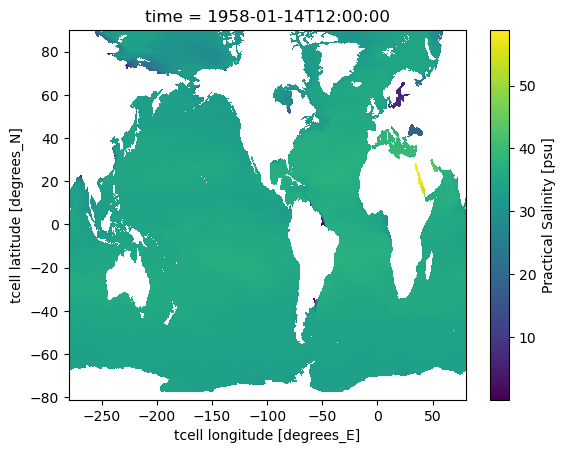

In [80]:
om2_ds.sss.isel(time=0).plot()

Note to plot this correctly, we should correct for the tripolar grid (see [Making Maps with Cartopy](https://cosima-recipes.readthedocs.io/en/latest/Tutorials/Making_Maps_with_Cartopy.html))

You only need to run `.to_dask()` once for each unique _file_id_, e.g. you can get the ocean wind stress vector in x & y in one dataset:

In [93]:
catalog_search.search(variable=['tau_x','tau_y']).to_dask()

<xarray.Dataset> Size: 9GB
Dimensions:   (time: 732, yu_ocean: 1080, xu_ocean: 1440)
Coordinates:
  * time      (time) datetime64[ns] 6kB 1958-01-14T12:00:00 ... 2018-12-14T12...
  * xu_ocean  (xu_ocean) float64 12kB -279.8 -279.5 -279.2 ... 79.5 79.75 80.0
  * yu_ocean  (yu_ocean) float64 9kB -81.02 -80.92 -80.81 ... 89.79 89.89 90.0
Data variables:
    tau_y     (time, yu_ocean, xu_ocean) float32 5GB dask.array<chunksize=(1, 216, 240), meta=np.ndarray>
    tau_x     (time, yu_ocean, xu_ocean) float32 5GB dask.array<chunksize=(1, 216, 240), meta=np.ndarray>
Attributes: (12/16)
    filename:                                 ocean_month.nc
    title:                                    ACCESS-OM2
    grid_type:                                mosaic
    grid_tile:                                1
    intake_esm_vars:                          ['tau_y', 'tau_x']
    intake_esm_attrs:realm:                   ocean
    ...                                       ...
    intake_esm_attrs:variable_cell_methods:   time: mean,time: mean,time: mea...
    intake_esm_attrs:variable_units:          dbar,Pa,(kg/m^3)*m,m,meter,m^2,...
    intake_esm_attrs:filename:                ocean_month.nc
    intake_esm_attrs:file_id:                 ocean_month
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   ocean_month.1mon

But you can't get a field from different _file_id_ (e.g. ocean and the sea-ice models) in the same xarray dataset:

In [97]:
catalog['025deg_jra55_iaf_omip2_cycle6'].search(variable=['sst','aice_m'], frequency='1mon').to_dask()

ValueError: Expected exactly one dataset. Received 2 datasets. Please refine your search or use `.to_dataset_dict()`.

# An example workflow

As a full example workflow, let's use the ACCESS-NRI catalog to carry out a simple analysis comparing anomalies of the global average ocean surface temperature from four ACCESS-CM2 data products. First we'll search directly for the products by their names and see what each of them are. 

In [81]:
catalog_filtered = catalog.search(name=["bx944", "by473", "by647", "by578"])

catalog_filtered

Now we'll load the Intake-ESM datastores for those products using the `to_source_dict` method because there is more than one of them. This will take a few seconds.

In [82]:
datastore_dict = catalog_filtered.to_source_dict()

datastore_dict

{'by473': <by473 catalog with 7 dataset(s) from 12149 asset(s)>,
 'by578': <by578 catalog with 7 dataset(s) from 1350 asset(s)>,
 'by647': <by647 catalog with 7 dataset(s) from 1350 asset(s)>,
 'bx944': <bx944 catalog with 7 dataset(s) from 12150 asset(s)>}

In these ACCESS-CM2 products, monthly global average ocean surface temperatures are available in the variable `temp_surface_ave`. We can open an xarray Dataset with `temp_surface_ave` from the Intake-ESM datastore for each product as follows. The opening of these files will be parallelized across our dask cluster - watch you dask dashboard when you execute the following cell. Note that, because the datasets here are small, we've chosen to load them immediately using `load()`.

In [83]:
dataset_dict = {
    name: datastore.search(variable="temp_surface_ave").to_dask().load()
    for name, datastore in datastore_dict.items()
}

The following function will calculate the anomalies of a provided dataset relative to the climatological mean of another dataset over the period 1971-2000. Here we'll calculate the anomalies for each product relative to the "bx944" standard historical run.

In [84]:
def anomalize(dataset, dataset_baseline, period=slice("1971","2000")):
    """
    Calculate the anomalies of ds relative to the climatological mean of ds_baseline over period
    """
    clim = dataset_baseline.sel(time=period).mean("member").groupby("time.month").mean("time")
    return dataset.groupby("time.month") - clim

In [85]:
anomalies_dict = {
    name: anomalize(dataset, dataset_dict["bx944"]) for name, dataset in dataset_dict.items()
}

To plot our data, we'll use a simple function that receives our dictionary of anomalies and plots the timeseries

In [86]:
import matplotlib.pyplot as plt
from datetime import datetime

def plot_temp_surface_ave(dataset_dict):
    for idx, (name, ds) in enumerate(dataset_dict.items()):
        data = ds["temp_surface_ave"].squeeze()
        data.plot.line(x="time", color=f"C{idx}", add_legend=False, label=name)
    
    plt.title("Global mean ocean surface temperature")
    plt.grid()
    plt.xlim([datetime(1969,1,1), datetime(2020,12,31)])
    
    # Add legend, removing duplicates due to multiple members
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

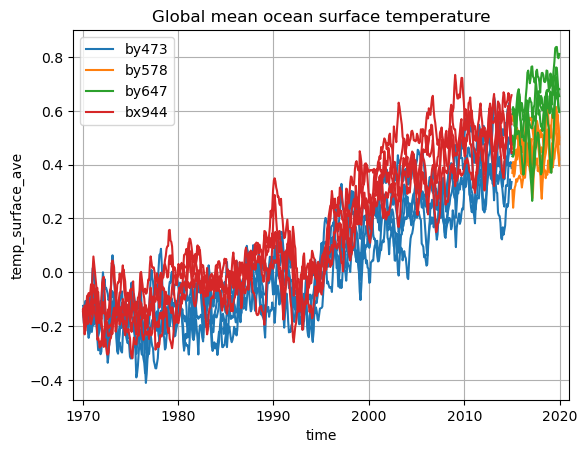

In [87]:
plot_temp_surface_ave(anomalies_dict)

Maybe we'd also like to add some CMIP6 ACCESS-CM2 data to our plot? That's easy because the [NCI CMIP Intake-ESM datastores](https://opus.nci.org.au/pages/viewpage.action?pageId=213713098) are included in the ACCESS-NRI catalog.

In [88]:
cmip6_datastore = catalog.search(name="cmip6.*", model="ACCESS-ESM1-5").to_source()

In this case however, there's no variable for global average ocean surface temperatures, so we'll have to calculate the area-weighted average ourselves from fields of ocean surface temperature.

In [89]:
tos_dataset = cmip6_datastore.search(
    source_id="ACCESS-CM2", 
    table_id="Omon", 
    variable_id="tos", 
    experiment_id="historical", 
    member_id="r1i1p1f1",
    file_type="f"
).to_dask()

area_dataset = cmip6_datastore.search(
    source_id="ACCESS-CM2", 
    table_id="Ofx", 
    variable_id="areacello", 
    experiment_id="historical", 
    member_id="r1i1p1f1",
    file_type="f"
).to_dask()

temp_surface_ave = tos_dataset["tos"].weighted(area_dataset["areacello"]).mean(["i", "j"]).to_dataset(name="temp_surface_ave").load()

Again, we'll compute the anomalies relative to the "bx944" data for consistency and add this to our dictionary of anomalies to pass on to our plotting function.

In [90]:
anomalies_dict["ACCESS-CM2 historical r1i1p1f1"] = anomalize(temp_surface_ave, dataset_dict["bx944"])

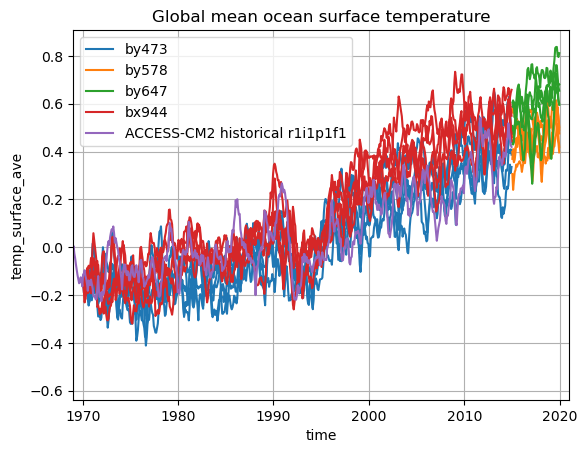

In [91]:
plot_temp_surface_ave(anomalies_dict)

## Challenge yourself

Can you add a CMIP6 ACCESS-CM2 SSP245 member to the plot?

Hint: CMIP6 experiments of the [SSP245 pathway](https://www.dkrz.de/en/communication/climate-simulations/cmip6-en/the-ssp-scenarios) have the `experiment_id = "ssp245"`

In [ ]:
client.close()